## If Running In Colab - Run Below Block First

In [1]:
# if running in colab, this block chooses tf 2.0:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

## Import Statements

In [1]:
# customary imports:
import tensorflow as tf
assert '2.' in tf.__version__  # make sure you're using tf 2.0
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import skimage
import cv2 as cv
import os
import datetime
import scipy
from skimage.morphology import reconstruction
from skimage import exposure
import scipy.io as sio
import h5py
import random
import shutil
import PIL
import imageio
import pydot 
import graphviz
import plotly.graph_objects as go
import preprocess_crop
from pathlib import Path
from tensorflow.keras import backend as K
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
#from keras.utils import CustomObjectScope
from mpl_toolkits.mplot3d import Axes3D
print('Tensorflow version: ' + tf.__version__)
%load_ext tensorboard

Tensorflow version: 2.0.0


Using TensorFlow backend.


In [2]:
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## If Running In Colab - Run the Next Two Blocks

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.chdir('/content/drive/Shared drives/BME 590L - ML in Imaging - Final Project/Final Project')

print("Current Working Directory is : " + os.getcwd())

Current Working Directory is : /content/drive/Shared drives/BME 590L - ML in Imaging - Final Project/Final Project


## Function to Convert .mat folder into Another File Format

In [2]:
def convert_MAP(directory,output_directory, min_shape, file_format = '.npy', search_keys = None, dtype = np.float32):
    # This program loops through given raw_data directory
    # and converts .mat files to .npy files
    new_dir = os.path.join(os.getcwd(), output_directory)
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    else:
        shutil.rmtree(new_dir)
        os.mkdir(new_dir)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".mat"): 
            #print(os.path.join(directory, filename))
            filepath = os.path.join(directory, filename)
            array_dict = {}
            try:
                f = h5py.File(filepath, 'r')
            except:
                f = sio.loadmat(filepath)
            for k, v in f.items():
                array_dict[k] = np.array(v, dtype = np.float32)
            # As we only need image info from dict (the last key) we do this
            if search_keys == None:
                search_keys = 'map' # out of struct of .mat files want "map"
                filtered_dict = dict(filter(lambda item: search_keys in item[0], array_dict.items()))
            else:
                filtered_dict = {}
                for i in range(len(search_keys)):
                    search_key = search_keys[i]
                    if search_key in array_dict:
                        filtered_dict[search_key] = array_dict[search_key]
            if len(filtered_dict) == 0:
                print('No Data to Meet Search Key Requirements: Datapoint Rejected -> ' + filepath)
            else:
                #print(list(array_dict.keys()))
                #print(filtered_dict)
                arrays = []
                for k, v in filtered_dict.items():
                    temp = np.transpose(v.astype(np.float32))
                    # To normalize data between [-1,1], use -> arrays = arrays/(np.max(arrays)/2) - 1
                    # To normalize data between [0,1], use -> arrays = arrays/(np.max(arrays))
                    # To normalize data between [0,255], 
                    #     use -> arrays = (arrays/(np.max(arrays))*255).astype(np.uint8)
                    temp = temp/(np.max(temp))
                    arrays.append(temp)
                for i in range(len(arrays)):
                    if len(arrays[i].shape) > 2:
                        #print(arrays[i].shape)
                        arrays[i] = np.mean(arrays[i], axis = 2)

                for i in range(len(arrays)):
                    new_dir_filepath = os.path.join(new_dir, filename.strip('.mat') 
                                                    + '_index'+str(i) + file_format)
                    array = arrays[i]
                    if array.shape[0] >= min_shape[0] and array.shape[1] >= min_shape[1]:
                        if file_format == '.npy':
                            np.save(new_dir_filepath, array, allow_pickle=True, fix_imports=True)
                        else:
                            imageio.imwrite(new_dir_filepath, array)
                    elif i == 0:
                        print('Min Size Not Met: Datapoint Rejected -> ' + filepath)
    return os.path.join(os.getcwd(), output_directory)

In [3]:
raw_directory = os.path.join(os.getcwd(), 'raw_data')
MIN_SHAPE = (128,128)
ENDPOINT_FOLDER_NAME = 'converted_data'
converted_dir = convert_MAP(raw_directory, ENDPOINT_FOLDER_NAME, MIN_SHAPE,
                            file_format = '.npy', search_keys = ['map_532'])

Min Size Not Met: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research Lab\PAM_Deep_Learning_Undersampling_Publication\Code\raw_data\190309_brain  6_Image3.mat
Min Size Not Met: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research Lab\PAM_Deep_Learning_Undersampling_Publication\Code\raw_data\190309_brain  6_Image4.mat
Min Size Not Met: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research Lab\PAM_Deep_Learning_Undersampling_Publication\Code\raw_data\20190508_thinnedskull_Epi_by 2    3_Image1.mat
No Data to Meet Search Key Requirements: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research Lab\PAM_Deep_Learning_Undersampling_Publication\Code\raw_data\reslt_OR_1 (5).mat
No Data to Meet Search Key Requirements: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research Lab\PAM_Deep_Learning_Undersampling_Publication\Code\raw_data\reslt_OR_1 (36).mat
No Data to Meet Search Key Requirements: Datapoint Rejected -> E:\Duke\Semester 1 - Fall 2019\Research L

## Function to Process Data by Denoising and Increasing Contrast

In [2]:
def data_cleaning(input_dir = 'converted_data', output_dir_name = 'cleaned_data',
                  output_file_format ='.npy', delete_previous = True):
    
    # This program seeks to remove some noise from the data
    # and make the underlying vessel structure more prominent
    # Input: input_dir -> directory that holds data to be cleaned
    #        output_dir -> directory to hold cleaned data
    # Output: None
    
    file_list = os.listdir(input_dir)
    clean_dir = os.path.join(os.getcwd(), output_dir_name)
    if not os.path.exists(clean_dir):
        os.mkdir(clean_dir)
    elif delete_previous == True:
        shutil.rmtree(clean_dir)
        os.mkdir(clean_dir)
    for file in file_list:
        filename = os.fsdecode(file)
        filepath = os.path.join(input_dir, filename)
        if filepath.endswith('.npy'):
            array = np.load(filepath)
        else:
            array = imageio.imread(filepath)
            
        # Defined data clean function below:
        array = data_clean_func(array)
    
        new_filepath = os.path.join(clean_dir, filename)
        if output_file_format == '.npy':
            new_filepath = Path(new_filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = new_filepath.with_suffix(output_file_format)
            np.save(new_filepath, array, allow_pickle=True, fix_imports=True)
        else:
            new_filepath = Path(new_filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = new_filepath.with_suffix(output_file_format)
            imageio.imwrite(new_filepath, array)
    return
def data_clean_func(image = -1):
    if len(image) == 1:
        print('Error in data_clean_func: Must input array to clean')
    else:
        #print(len(np.unique(image)))
        #clean_image = image
        '''
        plt.hist(image)
        plt.show()
        '''
        '''
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.show()
        '''
        threshold = 0.85
        default_fill = 0.0
        frac_of_high_clip = 1/9
        image[image > threshold] = default_fill
        image[image < frac_of_high_clip*(1.0-threshold)] = default_fill
        '''
        plt.imshow(image, cmap='gray')
        plt.title('After Clipping')
        plt.show()
        '''
        image = scipy.ndimage.median_filter(image, size=(4, 4))
        '''
        plt.imshow(image, cmap='gray')
        plt.title('After Median Filter')
        plt.show()
        '''
        image = skimage.filters.gaussian(image, sigma=0.01, output=None, mode='reflect', preserve_range=True)
        ####################################################################
        # Added to ensure negligible loss when converting to int16 
        # within exposure.equalize_adapthist
        image = (image/np.max(image)*(2**16)).astype(np.uint16)
        # A "Monkey Patch" could possibly be used as a cleaner solution, 
        # but would be more involved than is necessary for my application
        ####################################################################
        image = exposure.equalize_adapthist(image,kernel_size=image.shape[0]//8, clip_limit=0.005, nbins=2**13)
        image = image.astype(np.float64)
        '''
        plt.imshow(image, cmap='gray')
        plt.title('After Local Adapt Hist')
        plt.show()
        '''
        image = scipy.ndimage.median_filter(image, size=(3, 1))
        image = scipy.ndimage.median_filter(image, size=(1, 3))
        image = skimage.filters.gaussian(image, sigma=0.1, output=None, mode='reflect', preserve_range=True)
        image = exposure.rescale_intensity(image, in_range='image', out_range=(0.0,1.0))
        '''
        plt.imshow(image, cmap='gray')
        plt.title('Final Image')
        plt.show()
        '''
        '''
        plt.hist(image)
        plt.show()
        '''
        clean_image = image.astype(np.float32)
    return clean_image

In [3]:
input_dir_name = 'converted_data'
#dir_name = 'test_data'
input_data_dir = os.path.join(os.getcwd(), input_dir_name)
print('Starting Data Cleaning...')
data_cleaning(input_dir = input_data_dir, output_dir_name = 'cleaned_data',
                  output_file_format ='.tiff', delete_previous = True)
print('Ending Data Cleaning')

Starting Data Cleaning...
Ending Data Cleaning


## Function to Seperate Folder into Subfolder of /training /validation and /testing

In [6]:
def data_seperation(input_dir, dataset_percentages, 
                    delete_previous = False, file_format = '.npy', 
                    scale = 1):
    # Takes numpy array and creates data folder with seperate sections
    # for training, validation, and testing according to given percentages
    # Input: numpy dir -> contains file path to data folder of numpy files
    #        dataset_percentages -> (% train, % test) such that % train + % test = 100
    #        OR
    #        dataset_percentages -> (% train, % val, % test) such that % train + % val + % test = 100
    # Output: new folders for training and testing or training/validation/testing
    
    # If just train and test
    if len(dataset_percentages) == 2:
        # Making Main data folder
        new_dir = os.path.join(os.getcwd(), 'data')
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)
        
        # Making train subfolder
        train_dir = os.path.join(new_dir, 'train')
        if not os.path.exists(train_dir):
            os.mkdir(train_dir)
            train_dir = os.path.join(train_dir, 'input')
            os.mkdir(train_dir)
        elif delete_previous == True:
            shutil.rmtree(train_dir)
            os.mkdir(train_dir)
            train_dir = os.path.join(train_dir, 'input')
            os.mkdir(train_dir)
        
        # Making test subfolder
        test_dir = os.path.join(new_dir, 'test')
        if not os.path.exists(test_dir):
            os.mkdir(test_dir)
            test_dir = os.path.join(test_dir, 'input')
            os.mkdir(test_dir)
        elif delete_previous == True:
            shutil.rmtree(test_dir)
            os.mkdir(test_dir)
            test_dir = os.path.join(test_dir, 'input')
            os.mkdir(test_dir)


        file_list = os.listdir(input_dir)
        total_num_imgs = len(file_list)
        train_percent = dataset_percentages[0]
        test_percent = dataset_percentages[1]
        valid_inputs = (train_percent >= test_percent and train_percent <= 100 and
                        test_percent <= 100 and train_percent > 0 and test_percent > 0 and
                        train_percent + test_percent == 100)
        if valid_inputs:
            num_train = int(round(total_num_imgs * train_percent//100))
        else:
            num_train = int(round(total_num_imgs * 0.9))
            print('ERROR: Please input valid percentages for dataset division')
            print('In place of valid input the ratio 90% train, 10% test was used')
        
        index = 0
        random.shuffle(file_list)
        for file in file_list:
            filename = os.fsdecode(file)
            filepath = os.path.join(input_dir, filename)
            # Loads File
            if filepath.endswith('.npy'):
                array = np.load(filepath)
                array = array/np.max(array)*scale
            else:
                array = imageio.imread(filepath)
                array = array/np.max(array)*scale
            if index < num_train:
                new_filepath = os.path.join(train_dir, filename)
            else:
                new_filepath = os.path.join(test_dir, filename)
            # Saves File
            if file_format == '.npy':
                new_filepath = Path(new_filepath)
                new_filepath = new_filepath.with_suffix('')
                new_filepath = new_filepath.with_suffix(file_format)
                np.save(new_filepath, array, allow_pickle=True, fix_imports=True)
            else:
                new_filepath = Path(new_filepath)
                new_filepath = new_filepath.with_suffix('')
                new_filepath = new_filepath.with_suffix(file_format)
                imageio.imwrite(new_filepath, array)
            index += 1
        return train_dir, test_dir
    # If train, val, and test
    elif len(dataset_percentages) == 3:
        # Making Main data folder
        new_dir = os.path.join(os.getcwd(), 'data')
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)
            
        # Making train subfolder
        train_dir = os.path.join(new_dir, 'train')
        if not os.path.exists(train_dir):
            os.mkdir(train_dir)
            train_dir = os.path.join(train_dir, 'input')
            os.mkdir(train_dir)
        elif delete_previous == True:
            shutil.rmtree(train_dir)
            os.mkdir(train_dir)
            train_dir = os.path.join(train_dir, 'input')
            os.mkdir(train_dir)
        
        # Making val subfolder
        val_dir = os.path.join(new_dir, 'val')
        if not os.path.exists(val_dir):
            os.mkdir(val_dir)
            val_dir = os.path.join(val_dir, 'input')
            os.mkdir(val_dir)
        elif delete_previous == True:
            shutil.rmtree(val_dir)
            os.mkdir(val_dir)
            val_dir = os.path.join(val_dir, 'input')
            os.mkdir(val_dir)
        
        # Making test subfolder
        test_dir = os.path.join(new_dir, 'test')
        if not os.path.exists(test_dir):
            os.mkdir(test_dir)
            test_dir = os.path.join(test_dir, 'input')
            os.mkdir(test_dir)
        elif delete_previous == True:
            shutil.rmtree(test_dir)
            os.mkdir(test_dir)
            test_dir = os.path.join(test_dir, 'input')
            os.mkdir(test_dir)
            
        file_list = os.listdir(input_dir)
        total_num_imgs = len(file_list)
        train_percent = dataset_percentages[0]
        val_percent = dataset_percentages[1]
        test_percent = dataset_percentages[2]
        valid_inputs = (train_percent >= test_percent and train_percent >= val_percent 
                        and train_percent <= 100 and val_percent <= 100 and test_percent <= 100
                        and train_percent > 0 and val_percent > 0 and test_percent > 0 and
                        train_percent + val_percent + test_percent == 100)
        if valid_inputs:
            num_train = int(round(total_num_imgs * train_percent//100))
            num_val = int(round(total_num_imgs * val_percent//100))
        else:
            num_train = int(round(total_num_imgs * 0.9))
            num_val = int(round((total_num_imgs - num_train)/2))
            print('ERROR: Please input valid percentages for dataset division')
            print('In place of a valid input the ratio 90% train, 5% val, 5% test was used')
        
        index = 0
        random.shuffle(file_list)
        for file in file_list:
            filename = os.fsdecode(file)
            filepath = os.path.join(input_dir, filename)
            # Loads File
            if filepath.endswith('.npy'):
                array = np.load(filepath)
                array = array/np.max(array)*scale
            else:
                array = imageio.imread(filepath)
                array = array/np.max(array)*scale
            if index < num_train:
                new_filepath = os.path.join(train_dir, filename)
            elif index <= num_train + num_val:
                new_filepath = os.path.join(val_dir, filename)
            else:
                new_filepath = os.path.join(test_dir, filename)
            # Saves File
            if file_format == '.npy':
                new_filepath = Path(new_filepath)
                new_filepath = new_filepath.with_suffix('')
                new_filepath = new_filepath.with_suffix(file_format)
                np.save(new_filepath, array, allow_pickle=True, fix_imports=True)
            else:
                new_filepath = Path(new_filepath)
                new_filepath = new_filepath.with_suffix('')
                new_filepath = new_filepath.with_suffix(file_format)
                imageio.imwrite(new_filepath, array)
            index += 1
        return train_dir, val_dir, test_dir
    else:
        print('ERROR: Please divide into train/test or train/val/test')

In [7]:
input_dir = 'cleaned_data'
dataset_percentages = (80, 10, 10)
print('Starting Data Seperation...')
train_dir, val_dir, test_dir = data_seperation(input_dir, dataset_percentages, 
                                               delete_previous = True, file_format = '.tif', 
                                               scale = 2**16)
print('Ending Data Seperation...')

Starting Data Seperation...
Ending Data Seperation...


### Code Block to Show How Much of Data has been Placed in various Subfolders (train/val/test)

In [8]:
print('Length of raw_data directory = '+str(len(os.listdir('raw_data'))))
print('Length of converted_data directory = '+str(len(os.listdir('converted_data'))))
print('Rejected Files = ' + str(len(os.listdir('raw_data')) - len(os.listdir('converted_data'))))
print('Length of cleaned_data directory = '+str(len(os.listdir('cleaned_data'))))
print('Length of training directory = '+str(len(os.listdir(train_dir))))
print('Length of validation directory = '+str(len(os.listdir(val_dir))))
print('Length of test directory = '+str(len(os.listdir(test_dir))))

Length of raw_data directory = 391
Length of converted_data directory = 294
Rejected Files = 97
Length of cleaned_data directory = 294
Length of training directory = 235
Length of validation directory = 30
Length of test directory = 29


# Data Loading

## Padding Training Data and Adding Downsampled Image as Channel

In [9]:
def pad_img_and_add_down_channel(array, downsample_axis = 'x', downsample_ratio = [0,2], shape=[128,128]):
    if len(shape)>2:
        shape = shape[0:2]
    if len(array.shape) > 2:
        array = np.mean(array, axis = 2)
    array = array/np.max(array)
    down_image = np.array(array, dtype = np.float32)
    mask = np.ones(array.shape)
    #print(full_image.shape)
    if downsample_ratio[0] == 1:
        downsample_ratio[0] = 0
    elif downsample_ratio[1] == 1:
        downsample_ratio[1] = 0
    if downsample_axis == 'x':
        downsample_ratio = downsample_ratio[1]
        for j in range(array.shape[1]):
            if j%downsample_ratio!=0:
                mask[:, j] = 0
    elif downsample_axis == 'y':
        downsample_ratio = downsample_ratio[0]
        for i in range(array.shape[0]):
            if i%downsampling_ratio[1]!=0:
                mask[i, :] = 0
    elif downsample_axis == 'both':
        downsample_ratio_j = downsample_ratio[1]
        downsample_ratio_i = downsample_ratio[0]
        if downsample_ratio_j > 0:
            for j in range(array.shape[1]):
                if j%downsample_ratio[1]!=0:
                    mask[:, j] = 0
        if downsample_ratio_i > 0:
            for i in range(array.shape[0]):
                if i%downsample_ratio[0]!=0:
                    mask[i, :] = 0
    down_image = np.multiply(mask, down_image)
    full_i_shape = array.shape[0]
    full_j_shape = array.shape[1]
    if full_i_shape%shape[0] != 0:
        i_left = full_i_shape%shape[0]
        i_pad = (shape[0] - i_left)//2
        rest_i = (shape[0] - i_left)%2
    else:
        i_left = 0
        i_pad = 0
        rest_i = 0
    if full_j_shape%shape[1] != 0:
        j_left = full_j_shape%shape[1]
        j_pad = (shape[1] - j_left)//2
        rest_j = (shape[1] - j_left)%2
    else:
        j_left = 0
        j_pad = 0
        rest_j = 0
    
    #print('i_left = '+str(i_left))
    #print('j_left = '+str(j_left))
    #print('i_pad = '+str(i_pad))
    #print('j_pad = '+str(j_pad))
    #print('rest_i = '+str(rest_i))
    #print('rest_j = '+str(rest_j))
    full_image = np.zeros((full_i_shape, full_j_shape, 3), dtype = np.float32)
    full_image[...,0] = array # Target Array
    full_image[...,1] = down_image # Downsampled Array
    full_image[...,2] = mask # Mask Array - for dispay
    pad_image = np.pad(full_image, [(i_pad, ), (j_pad, ), (0,)], mode='constant', constant_values = 0)
    padded_multi_chan_image = np.pad(pad_image, [(0, rest_i), (0, rest_j), (0, 0)], mode='constant', constant_values = 0)
    return padded_multi_chan_image

Original Image Shape = (224, 224)
Padded Image Shape = (224, 224, 3)


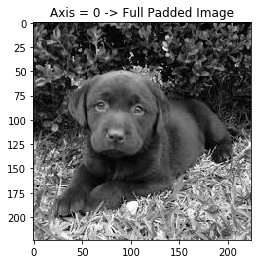

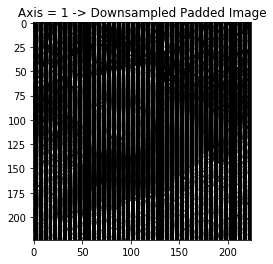


Downsampled Image Non-Zero Pixel % = 0.20085299744897958



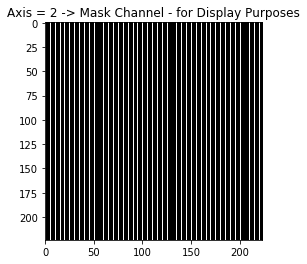

In [103]:
'''
# TESTING
img = np.array(imageio.imread('puppy.jpg'))
if len(img.shape)>2:
    img = np.mean(img, axis = 2)
img = img/np.max(img)
#img = img[14:210,:113]
#img = np.hstack((img[:,:], img))
print('Original Image Shape = '+str(img.shape))
padded_multi_chan_image = pad_img_and_add_down_channel(img, downsample_axis = 'both', 
                                                       downsample_ratio = [0,5], shape = (224,224))
print('Padded Image Shape = '+str(padded_multi_chan_image.shape))
plt.imshow(padded_multi_chan_image[:,:,0], cmap = 'gray')
plt.title('Axis = 0 -> Full Padded Image')
plt.show()
plt.imshow(padded_multi_chan_image[:,:,1], cmap = 'gray')
plt.title('Axis = 1 -> Downsampled Padded Image')
plt.show()
print('\n'+'Downsampled Image Non-Zero Pixel % = '+str(np.mean(padded_multi_chan_image[..., 1]>0))+'\n')
plt.imshow(padded_multi_chan_image[:,:,2], cmap = 'gray')
plt.title('Axis = 2 -> Mask Channel - for Display Purposes')
plt.show()
'''

In [48]:
def standardize_dir(input_dir = 'data/train/input', downsample_axis = 'x', downsample_ratio = [0,2], 
                      standard_shape = (128, 128, 1), file_format = '.tif'):
    file_list = os.listdir(input_dir)
    for file in file_list:
        # Load Image
        filename = os.fsdecode(file)
        filepath = os.path.join(input_dir, filename)
        if filepath.endswith('.npy'):
            array = np.load(filepath)
        else:
            array = imageio.imread(filepath)
            array = np.array(array)
        temp = pad_img_and_add_down_channel(array, downsample_axis = downsample_axis, 
                                            downsample_ratio = downsample_ratio, shape = standard_shape)
        # Save Image
        if file_format == '.npy':
            new_filepath = Path(filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = Path(os.path.abspath(new_filepath)+ '_pad')
            new_filepath = new_filepath.with_suffix(file_format)
            np.save(new_filepath, temp, allow_pickle=True, fix_imports=True)
        else:
            new_filepath = Path(filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = Path(os.path.abspath(new_filepath)+ '_pad')
            new_filepath = new_filepath.with_suffix(file_format)
            imageio.imwrite(new_filepath, temp)
        os.remove(filepath)
    return len(os.listdir(input_dir))

In [11]:
input_dir = 'data/train/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_train_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,5], 
                                               standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_train_image_pool = ' + str(total_train_image_pool))

total_train_image_pool = 235


In [12]:
input_dir = 'data/val/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_val_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,5], 
                                             standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_val_image_pool = ' + str(total_val_image_pool))

total_val_image_pool = 30


In [13]:
input_dir = 'data/test/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_test_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,5], 
                                                 standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_test_image_pool = ' + str(total_test_image_pool))

total_test_image_pool = 29


## Data Loader and Augmentation

In [3]:
def preprocess_function(image, prob = 0.1, max_shift = 0.10, lower = 1.0, upper = 1.25, seed=7):
    img = image.copy()
    #img = add_rand_contrast(img, lower, upper, prob, seed=seed)
    img = add_gaussian_noise(img, std = 0.1, prob = prob, seed=seed)
    '''
    img = tf.keras.preprocessing.image.random_zoom(img,zoom_range=(0.8,2),row_axis=0,col_axis=1,channel_axis=2,
                                                   fill_mode='nearest',cval=0.0,interpolation_order=3)
    '''
    img = exposure.rescale_intensity(img, in_range = 'image', out_range = (0.0,1.0))
    #print(img.shape)
    return img

In [4]:
def preprocess_function_valtest(image):
    img = image.copy()
    img = exposure.rescale_intensity(img, in_range='image', out_range=(0.0,1.0))
    return img

In [5]:
def add_gaussian_noise(batch, mean_val = 0.0, std = 0.1, prob = 0.1, seed = None):
    rand_var = tf.random.uniform(shape = [1], seed=seed).numpy()[0]
    batch_and_noise = batch
    if rand_var < prob:
        noise = tf.random.normal(shape=tf.shape(batch), mean=mean_val, 
                                 stddev=std, dtype=tf.float32, seed=seed)
        batch_and_noise = tf.math.add(batch,noise)
        batch_and_noise = batch_and_noise.numpy()
    return batch_and_noise

In [6]:
# NOT USED -> but Thought It Might be Useful in the Future
def add_rand_bright_shift(batch, max_shift = 0.12, prob = 0.1, seed=None):
    # Equivalent to adjust_brightness() using a delta randomly
    # picked in the interval [-max_delta, max_delta) with a
    # given probability that this function is performed on an image
    rand_var = tf.random.uniform(shape = [1], seed=seed).numpy()[0]
    batch_and_bright_shift = batch
    if rand_var < prob:
        batch_and_bright_shift = tf.image.random_brightness(image=batch, max_delta=max_shift, 
                                                            seed=seed)
        batch_and_bright_shift = batch_and_bright_shift.numpy()
    return batch_and_bright_shift

In [7]:
def add_rand_contrast(batch, lower = 0.2, upper = 1.8, prob = 0.1, seed=None):
    # For each channel, this Op computes the mean of the image pixels in the channel 
    # and then adjusts each component x of each pixel to (x - mean) * contrast_factor + mean
    # with a given probability that this function is performed on an image
    rand_var = tf.random.uniform(shape = [1],seed=seed).numpy()[0]
    batch_and_rand_contrast = batch
    if rand_var < prob:
        batch_and_rand_contrast = tf.image.random_contrast(image=batch, lower=lower, 
                                                           upper=upper, seed=seed)
        batch_and_rand_contrast = batch_and_rand_contrast.numpy()
    return batch_and_rand_contrast

In [8]:
STANDARD_IMAGE_SHAPE = (128,128,1) # See Above Section to Verify Shape
MIN_SHAPE = (STANDARD_IMAGE_SHAPE[0],STANDARD_IMAGE_SHAPE[1])
BATCH_SIZE = 16
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

In [9]:
data_gen_args_train = dict(horizontal_flip=True,
                           vertical_flip = True,
                           rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           fill_mode = 'constant',
                           cval = 0,
                           preprocessing_function = preprocess_function,
                           dtype='float32')
train_datagen = ImageDataGenerator(**data_gen_args_train)
data_gen_args_test_and_val = dict(preprocessing_function = preprocess_function_valtest)
test_and_val_datagen = ImageDataGenerator(**data_gen_args_test_and_val)
seed = 7
tf.random.set_seed(seed)
# Flow From Directory Generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=MIN_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None,
                                                    ####################
                                                    # Monkey Patch - preprocess_crop.py
                                                    interpolation = 'lanczos:random',
                                                    ####################
                                                    color_mode='rgb',
                                                    shuffle = True, 
                                                    seed=seed)

validation_generator = test_and_val_datagen.flow_from_directory(val_dir,
                                                                target_size=MIN_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode=None,
                                                                ####################
                                                                # Monkey Patch - preprocess_crop.py
                                                                interpolation = 'lanczos:center',
                                                                ####################
                                                                color_mode='rgb',
                                                                shuffle = True, 
                                                                seed=seed)
test_generator = test_and_val_datagen.flow_from_directory(test_dir,
                                                          target_size=MIN_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode=None,
                                                          ####################
                                                          # Monkey Patch - preprocess_crop.py
                                                          interpolation = 'lanczos:center', 
                                                          ####################
                                                          color_mode='rgb', 
                                                          shuffle = False,
                                                          seed=seed)

Found 235 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 29 images belonging to 1 classes.


In [10]:
def custom_generator_wrapper(gen):
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # Third channel is empty and only there for compatibility
        yield down_img[..., None], orig_img[..., None]

## Model Definition for U-Net

In [11]:
'''
# Model Subclassing with Physical Layer (Legacy)
from UNet_model_simp_with_phys_layer import UNet_model_simp_with_phys_layer
'''
'''
# Model Subclassing without Physical Layer
from UNet_model_simp import UNet_model_simp
'''

# USING FUNCTIONAL API

#from UNet_model_simp_func import getModel
#from ResUNet import getModel
#from ICL_ResUNet import getModel
from FD_UNet import getModel

from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
from model_utils import SavingMetric

### Hyperparameters

In [16]:
EPOCHS = 20 #400 #500 #3500
FILTERS = 64
INITIAL_LR = 0.001
ACTIVATION = 'elu'
KERNEL_SIZE = 3 # 3x3 kernel
AUGMENTATIONS = 10
B1 = 0.99
B2 = 0.01

### Compiling and Training Model

In [13]:
# Subclassed Model
#unet_model = UNet_model_simp(filters = FILTERS, kernel_size = KERNEL_SIZE, activation = ACTIVATION)

In [14]:
INPUT_SHAPE=STANDARD_IMAGE_SHAPE
# Functional API Model
unet_model = getModel(input_shape=INPUT_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION)

In [17]:
#unet_model = saved_model
#unet_model = best_unet_model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = INITIAL_LR, amsgrad=False),  # pick an optimizer
                   loss=SavingMetric,#model_loss(B1,B2),  # pick a loss
                   metrics=['mean_absolute_error', 'mean_squared_error', KLDivergence, SavingMetric, PSNR, SSIM])  # pick a metric to monitor

In [18]:
train_dir = 'data/train/input'
val_dir = 'data/val/input'
model_dir = 'model_dir'
delete_previous=True

if not os.path.exists(model_dir):
            os.mkdir(model_dir)
elif delete_previous == True:
            shutil.rmtree(model_dir)
            os.mkdir(model_dir)
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, 'saved_model.epoch_{epoch:02d}-SSIM_{val_SSIM:.5f}-PSNR_{val_PSNR:.5f}-metric_{val_SavingMetric:.5f}.h5'),
                                                   monitor='val_SavingMetric', verbose=0, 
                                                   save_best_only=True, save_weights_only=False, 
                                                   mode='min', save_freq='epoch')]
'''
logdir = "logs\\scalars\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(logdir):
    os.mkdir(logdir)
else:
    shutil.rmtree(logdir)
    os.mkdir(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
my_callbacks.append(tensorboard_callback)
%tensorboard --logdir logs/scalars
'''

history = unet_model.fit_generator(custom_generator_wrapper(train_generator),
                                   steps_per_epoch=AUGMENTATIONS*np.ceil(len(os.listdir(train_dir))/BATCH_SIZE),
                                   epochs=EPOCHS, 
                                   callbacks=my_callbacks, 
                                   validation_data=custom_generator_wrapper(validation_generator),
                                   validation_steps=np.ceil(len(os.listdir(val_dir))/BATCH_SIZE), 
                                   max_queue_size = 128,
                                   shuffle = True)

Epoch 1/20
150/150 [==============================] - 270s 2s/step - loss: 1.0200 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0036 - KLDivergence: 0.0151 - SavingMetric: 1.0159 - PSNR: 28.8757 - SSIM: 0.7903 - val_loss: 3.5441 - val_mean_absolute_error: 2.7889 - val_mean_squared_error: 2332.5745 - val_KLDivergence: -0.0018 - val_SavingMetric: 3.5490 - val_PSNR: -20.3172 - val_SSIM: 0.7169
Epoch 2/20
150/150 [==============================] - 219s 1s/step - loss: 0.9512 - mean_absolute_error: 0.0319 - mean_squared_error: 0.0042 - KLDivergence: 0.0100 - SavingMetric: 0.9507 - PSNR: 29.4465 - SSIM: 0.8270 - val_loss: 1.5946 - val_mean_absolute_error: 0.0730 - val_mean_squared_error: 1.5828 - val_KLDivergence: 0.0579 - val_SavingMetric: 1.5977 - val_PSNR: 15.3476 - val_SSIM: 0.8849
Epoch 3/20
150/150 [==============================] - 212s 1s/step - loss: 0.9881 - mean_absolute_error: 0.0331 - mean_squared_error: 0.0042 - KLDivergence: 0.0131 - SavingMetric: 0.9875 - PSNR: 29.086

### Tensorboard Launch

In [ ]:
#%tensorboard --logdir logs/scalars

### Load the Best Model From Model Dir

In [19]:
from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
from model_utils import SavingMetric
print('Loading Best Model...')
model_dir = 'model_dir'
filename = os.listdir(model_dir)[-1]
directory = os.path.join(os.getcwd(), model_dir)
directory = os.path.join(directory, filename)
best_unet_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                        'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                        'SavingMetric':SavingMetric})
print('Done Loading Best Model(' + filename + ') from: ' + model_dir)

Loading Best Model...
Done Loading Best Model(saved_model.epoch_06-SSIM_0.92442-PSNR_28.57290-metric_0.89694.h5) from: model_dir


## Analysis of Model Training

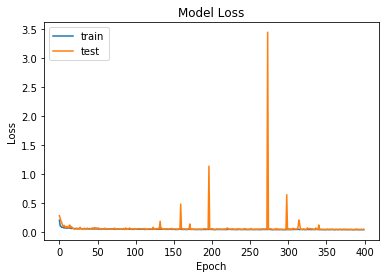

In [18]:
offset = 0
data1 = history.history['loss'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_loss'][offset:]
plt.plot(epochs, data2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

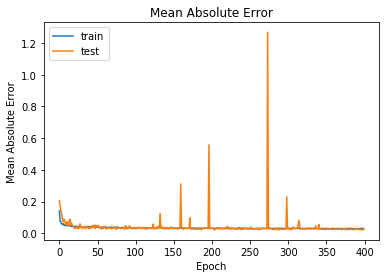

In [19]:
offset = 0
data1 = history.history['mean_absolute_error'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_mean_absolute_error'][offset:]
plt.plot(epochs, data2)
plt.title('Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

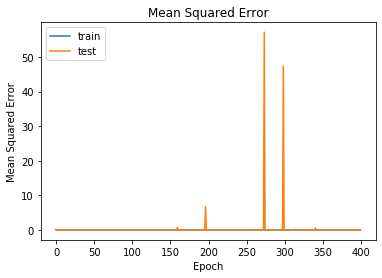

In [20]:
offset = 0
data1 = history.history['mean_squared_error'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_mean_squared_error'][offset:]
plt.plot(epochs, data2)
plt.title('Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

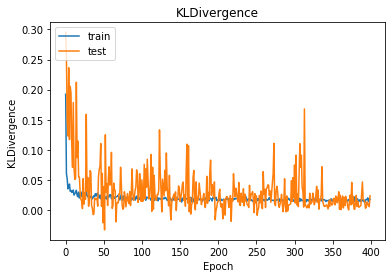

In [21]:
offset = 0
data1 = history.history['KLDivergence'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_KLDivergence'][offset:]
plt.plot(epochs, data2)
plt.title('KLDivergence')
plt.ylabel('KLDivergence')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

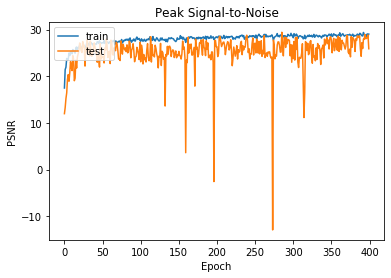

In [22]:
offset = 0
data1 = history.history['PSNR'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_PSNR'][offset:]
plt.plot(epochs, data2)
plt.title('Peak Signal-to-Noise')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

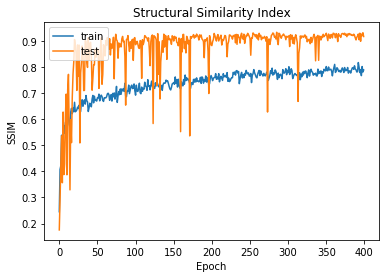

In [23]:
offset = 0
data1 = history.history['SSIM'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_SSIM'][offset:]
plt.plot(epochs, data2)
plt.title('Structural Similarity Index')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

### Model Architecture

In [20]:
unet_model.summary()

Model: "UNet_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           img[0][0]                        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 1)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         dropout[0][0]                    
_________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(best_unet_model, 'saved_model_FD_UNet_0i-5j_down/unet_arch_TB.png', show_shapes=True, rankdir='TB', dpi=300)

## Save Model

### For Keras Subclassing

In [19]:
def save_history(history, output_dir):
    directory = os.path.join(os.getcwd(), output_dir)
    if not os.path.exists(directory):
        os.mkdir(directory)
    filepath = os.path.join(directory, 'history')
    np.savez(filepath, **history.history)

In [173]:
# Using Keras Subclassing
output_dir = 'saved_uni_down_80_patch_v2'
if not os.path.exists(os.path.join(os.getcwd(), output_dir)):
    print('Creating Directory...')
    os.mkdir(os.path.join(os.getcwd(), output_dir))
#unet_model.trainable = False
print('Saving Model...')
tf.keras.models.save_model(unet_model,
                           output_dir,
                           overwrite=True,
                           include_optimizer=True,
                           save_format='tf',
                           signatures=None,
                           options=None)
print('Saving History...')
save_history(history, output_dir)
print('Done Saving')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_uni_down_80_patch_v2\assets


### For Functional API

In [25]:
def save_history(history, output_dir):
    directory = os.path.join(os.getcwd(), output_dir)
    if not os.path.exists(directory):
        os.mkdir(directory)
    filepath = os.path.join(directory, 'history')
    np.savez(filepath, **history.history)

In [26]:
# Using Functional API
output_dir = 'saved_model_FD_UNet_0i-5j_down'
filename = 'saved_model.h5'
if not os.path.exists(os.path.join(os.getcwd(), output_dir)):
    print('Creating Directory...')
    os.mkdir(os.path.join(os.getcwd(), output_dir))
else:
    print('Directory Already Exists...')
print('Saving Model...')
directory = os.path.join(os.getcwd(), output_dir)
directory = os.path.join(directory, filename)
unet_model.save(directory)
print('Saving History...')
save_history(history, output_dir)
print('Done Saving !!!')

Directory Already Exists...
Saving Model...
Saving History...
Done Saving !!!


## Load Model (only for prediction with Keras Subclassing)

### For Keras Subclassing

#### Copy and Paste Hyperparameters Used (From Text File)

In [31]:
def load_history_from_saved(directory):
    direct = os.path.join(os.getcwd(), directory)
    filepath = os.path.join(direct, 'history.npz')
    array = np.load(filepath, allow_pickle=True, fix_imports=True)
    return array

In [32]:
def show_history(hist, offset=50):
    data1 = history.history['loss'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_loss'][offset:]
    plt.plot(epochs, data2)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['mean_absolute_error'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_mean_absolute_error'][offset:]
    plt.plot(epochs, data2)
    plt.title('Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['mean_squared_error'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_mean_squared_error'][offset:]
    plt.plot(epochs, data2)
    plt.title('Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['KLDivergence'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_KLDivergence'][offset:]
    plt.plot(epochs, data2)
    plt.title('KLDivergence')
    plt.ylabel('KLDivergence')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['PSNR'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_PSNR'][offset:]
    plt.plot(epochs, data2)
    plt.title('Peak Signal-to-Noise')
    plt.ylabel('PSNR')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['SSIM'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_SSIM'][offset:]
    plt.plot(epochs, data2)
    plt.title('Structural Similarity Index')
    plt.ylabel('SSIM')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()

In [185]:
from UNet_model_simp import UNet_model_simp
EPOCHS = 500 #3500
FILTERS = 64#32
INITIAL_LR = 0.001
ACTIVATION = 'elu'
KERNEL_SIZE = 3 # 3x3 kernel

In [186]:
token = UNet_model_simp(filters = FILTERS, kernel_size = KERNEL_SIZE, activation = ACTIVATION)
token.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = INITIAL_LR),  # pick an optimizer
              loss=token.loss_func,  # pick a loss
              metrics=['mean_absolute_error'])  # pick a metric to monitor
hist_tok = token.fit_generator(custom_generator_wrapper(train_generator),
                               steps_per_epoch=1,#np.ceil(len(os.listdir(train_dir))/ BATCH_SIZE),
                               epochs=1,
                               validation_data=custom_generator_wrapper(validation_generator),
                               validation_steps=1,#np.ceil(len(os.listdir(val_dir))/ BATCH_SIZE),
                               shuffle = True)

1/1 [==============================] - 4s 4s/step - loss: 1.1236 - mean_absolute_error: 1.1236 - val_loss: 0.2689 - val_mean_absolute_error: 0.2689


In [187]:
from UNet_model_simp import UNet_model_simp
from UNet_model_simp import UNet_DownBlock
from UNet_model_simp import UNet_UpBlock
from UNet_model_simp import Conv2D_BatchNorm
from UNet_model_simp import Upsample_Conv2D_BatchNorm
from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
print('Loading Model...')
custom_objects={'UNet_DownBlock' : UNet_DownBlock,
                'UNet_UpBlock' : UNet_UpBlock,
                'Conv2D_BatchNorm' : Conv2D_BatchNorm,
                'Upsample_Conv2D_BatchNorm' : Upsample_Conv2D_BatchNorm,
                'total_loss' : token.loss_func}
input_dir = 'saved_uni_down_80_patch_v2'
saved_model = tf.keras.models.load_model(input_dir, custom_objects = custom_objects, compile = False)
saved_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = INITIAL_LR),  # pick an optimizer
                    loss=token.loss_func,  # pick a loss
                    metrics=['mean_absolute_error', 'mean_squared_error', PSNR, SSIM])  # pick a metric to monitor
print('Done Loading Model from: ' + input_dir)

Loading Model...
Done Loading Model from: saved_uni_down_80_patch_v2


#### Load History From File

In [ ]:
input_dir = 'saved_uni_down_80_patch_v2'
saved_hist = load_history_from_saved(input_dir)

#### Show History

In [ ]:
show_history(saved_hist, offset=50)

### For Functional API

In [13]:
from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
from model_utils import SavingMetric
print('Loading Model...')
input_dir = 'saved_model_FD_UNet_0i-5j_down\\best_models'
filename = os.listdir(input_dir)[-1]# 'saved_model.h5'
directory = os.path.join(os.getcwd(), input_dir)
directory = os.path.join(directory, filename)
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                    'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                    'SavingMetric':SavingMetric})
print('Done Loading Best Model(' + filename + ') from: ' + input_dir)

Loading Model...
Done Loading Best Model(saved_model.286-0.93291.h5) from: saved_model_FD_UNet_0i-5j_down\best_models


#### Load History From File

In [ ]:
def load_history_from_saved(directory):
    direct = os.path.join(os.getcwd(), directory)
    filepath = os.path.join(direct, 'history.npz')
    array = np.load(filepath, allow_pickle=True, fix_imports=True)
    return array

In [ ]:
input_dir = 'saved_uni_down_80_patch_func'
saved_hist = load_history_from_saved(input_dir)

#### Show History

In [ ]:
def show_history(hist, offset=50):
    data1 = history.history['loss'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_loss'][offset:]
    plt.plot(epochs, data2)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['mean_absolute_error'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_mean_absolute_error'][offset:]
    plt.plot(epochs, data2)
    plt.title('Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['mean_squared_error'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_mean_squared_error'][offset:]
    plt.plot(epochs, data2)
    plt.title('Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['KLDivergence'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_KLDivergence'][offset:]
    plt.plot(epochs, data2)
    plt.title('KLDivergence')
    plt.ylabel('KLDivergence')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['PSNR'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_PSNR'][offset:]
    plt.plot(epochs, data2)
    plt.title('Peak Signal-to-Noise')
    plt.ylabel('PSNR')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()
    
    data1 = history.history['SSIM'][offset:]
    epochs = range(offset,len(data1)+offset)
    plt.plot(epochs, data1)
    data2 = history.history['val_SSIM'][offset:]
    plt.plot(epochs, data2)
    plt.title('Structural Similarity Index')
    plt.ylabel('SSIM')
    plt.xlabel('Epoch')
    plt.legend(["train", "test"], loc = "upper left")
    #plt.xticks(epochs)
    plt.show()

In [ ]:
show_history(saved_hist, offset=50)

## Analysis of Model Output/Results

In [20]:
predictions_curr = best_unet_model.predict_generator(custom_generator_wrapper(test_generator), steps = 1)
print(predictions_curr.shape)

(16, 128, 128, 1)


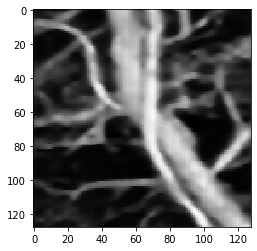

In [21]:
plt.imshow(predictions_curr[14,:,:,0], cmap = 'gray')
plt.show()

# Showing Results with Test Images:

### Downsampling the Image in testing/input directory

In [4]:
def pad_img_and_add_down_channel(array, downsample_axis = 'x', downsample_ratio = [0,2], shape=[128,128]):
    if len(shape)>2:
        shape = shape[0:2]
    if len(array.shape) > 2:
        array = np.mean(array, axis = 2)
    array = array/np.max(array)
    down_image = np.array(array, dtype = np.float32)
    mask = np.ones(array.shape)
    #print(full_image.shape)
    if downsample_ratio[0] == 1:
        downsample_ratio[0] = 0
    elif downsample_ratio[1] == 1:
        downsample_ratio[1] = 0
    if downsample_axis == 'x':
        downsample_ratio = downsample_ratio[1]
        for j in range(array.shape[1]):
            if j%downsample_ratio!=0:
                mask[:, j] = 0
    elif downsample_axis == 'y':
        downsample_ratio = downsample_ratio[0]
        for i in range(array.shape[0]):
            if i%downsampling_ratio[1]!=0:
                mask[i, :] = 0
    elif downsample_axis == 'both':
        downsample_ratio_j = downsample_ratio[1]
        downsample_ratio_i = downsample_ratio[0]
        if downsample_ratio_j > 0:
            for j in range(array.shape[1]):
                if j%downsample_ratio[1]!=0:
                    mask[:, j] = 0
        if downsample_ratio_i > 0:
            for i in range(array.shape[0]):
                if i%downsample_ratio[0]!=0:
                    mask[i, :] = 0
    down_image = np.multiply(mask, down_image)
    full_i_shape = array.shape[0]
    full_j_shape = array.shape[1]
    if full_i_shape%shape[0] != 0:
        i_left = full_i_shape%shape[0]
        i_pad = (shape[0] - i_left)//2
        rest_i = (shape[0] - i_left)%2
    else:
        i_left = 0
        i_pad = 0
        rest_i = 0
    if full_j_shape%shape[1] != 0:
        j_left = full_j_shape%shape[1]
        j_pad = (shape[1] - j_left)//2
        rest_j = (shape[1] - j_left)%2
    else:
        j_left = 0
        j_pad = 0
        rest_j = 0
    
    #print('i_left = '+str(i_left))
    #print('j_left = '+str(j_left))
    #print('i_pad = '+str(i_pad))
    #print('j_pad = '+str(j_pad))
    #print('rest_i = '+str(rest_i))
    #print('rest_j = '+str(rest_j))
    full_image = np.zeros((full_i_shape, full_j_shape, 3), dtype = np.float32)
    full_image[...,0] = array # Target Array
    full_image[...,1] = down_image # Downsampled Array
    full_image[...,2] = mask # Mask Array - for dispay
    pad_image = np.pad(full_image, [(i_pad, ), (j_pad, ), (0,)], mode='constant', constant_values = 0)
    padded_multi_chan_image = np.pad(pad_image, [(0, rest_i), (0, rest_j), (0, 0)], mode='constant', constant_values = 0)
    return padded_multi_chan_image

In [5]:
def standardize_dir(input_dir = 'data/train/input', downsample_axis = 'x', downsample_ratio = [0,2], 
                      standard_shape = (128, 128, 1), file_format = '.tif'):
    file_list = os.listdir(input_dir)
    for file in file_list:
        # Load Image
        filename = os.fsdecode(file)
        filepath = os.path.join(input_dir, filename)
        if filepath.endswith('.npy'):
            array = np.load(filepath)
        else:
            array = imageio.imread(filepath)
            array = np.array(array)
        temp = pad_img_and_add_down_channel(array, downsample_axis = downsample_axis, 
                                            downsample_ratio = downsample_ratio, shape = standard_shape)
        # Save Image
        if file_format == '.npy':
            new_filepath = Path(filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = Path(os.path.abspath(new_filepath)+ '_pad')
            new_filepath = new_filepath.with_suffix(file_format)
            np.save(new_filepath, temp, allow_pickle=True, fix_imports=True)
        else:
            new_filepath = Path(filepath)
            new_filepath = new_filepath.with_suffix('')
            new_filepath = Path(os.path.abspath(new_filepath)+ '_pad')
            new_filepath = new_filepath.with_suffix(file_format)
            imageio.imwrite(new_filepath, temp)
        os.remove(filepath)
    return len(os.listdir(input_dir))

In [53]:
num_img = standardize_dir(input_dir = 'testing/input', downsample_axis = 'x', downsample_ratio = [0,5], 
                          standard_shape = (128,128,1), file_format = '.tif')

### Showing Results on Test Image

In [23]:
def preprocess_function_testing(image, shape = (128,128,1)):
    img = image.copy()
    #print(img.shape)
    img = exposure.rescale_intensity(img, in_range='image', out_range=(0.0,1.0))
    img = np.array(img, dtype = np.float32)
    #print(img.shape)
    #plt.imshow(img[:,:,0], cmap='gray')
    #plt.show()
    return img

In [24]:
data_gen_args_testing = dict(#featurewise_center=True,
                          #featurewise_std_normalization=True,
                          preprocessing_function = preprocess_function_testing)
testing_datagen = ImageDataGenerator(**data_gen_args_testing)

# Provide the same seed and keyword arguments to the fit and flow methods
testing_dir = 'testing'

testing_generator = testing_datagen.flow_from_directory(testing_dir,target_size=(128,128),
                                                        batch_size=1,class_mode=None,color_mode='rgb', shuffle = False)

Found 1 images belonging to 1 classes.


In [25]:
def custom_generator_wrapper(gen):
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # Third channel is empty and only there for compatibility
        yield down_img[..., None], orig_img[..., None]

In [26]:
dir_name = 'testing/input'
saved_model = best_unet_model

testing/input\brain_image_crop_1_128by128_pad.tif
(128, 128)


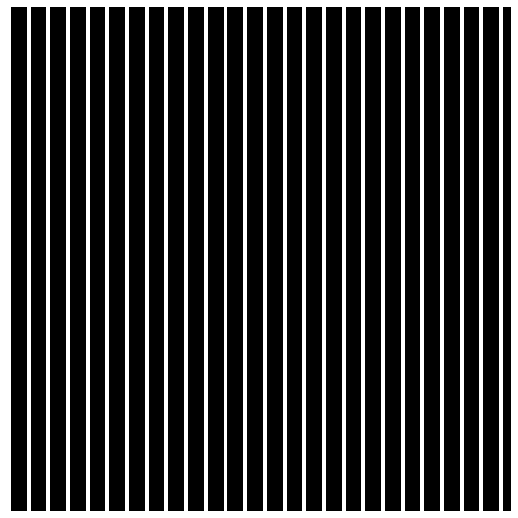

total elements in mask = 16384
total elements not downsampled = 3328.0
max value in mask = 1.0
min value in mask = 0.0
mean of mask = 0.203125


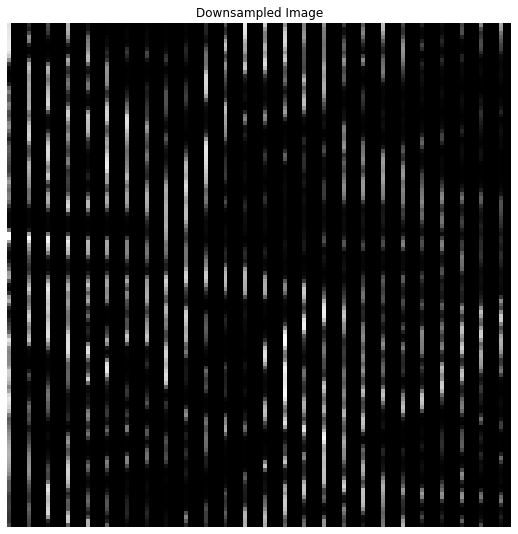

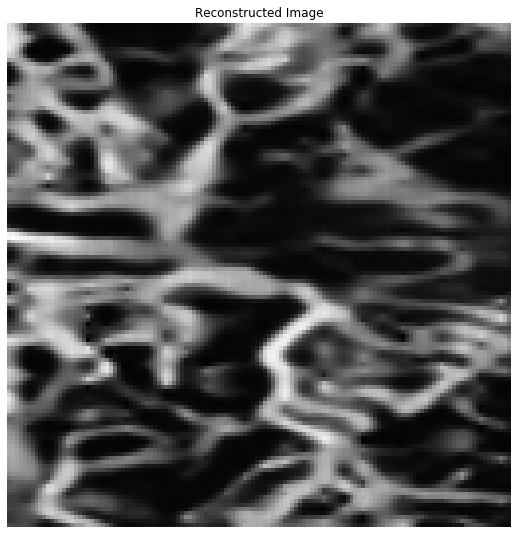

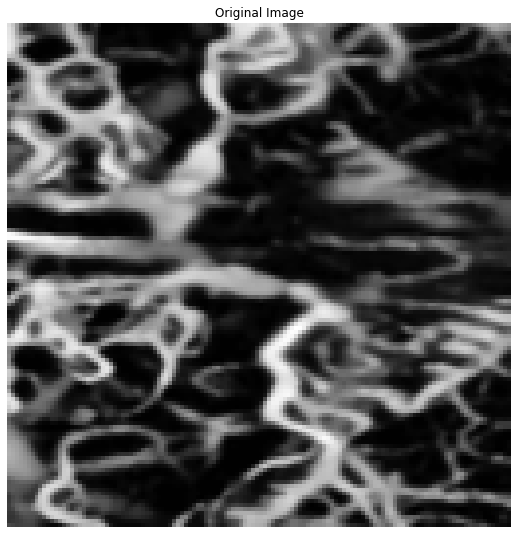

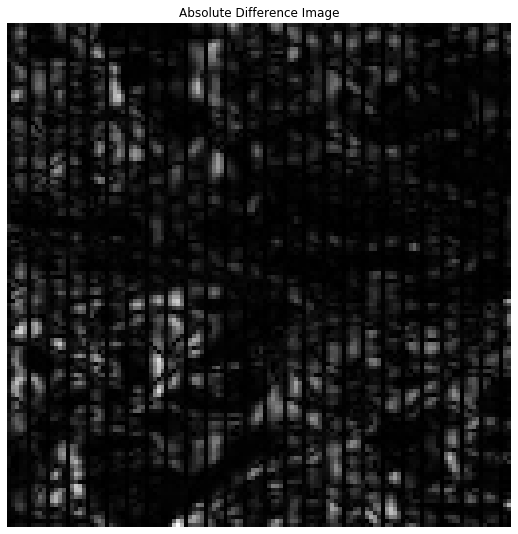

Mean Absolute Difference: 0.04275102
Max Absolute Difference: 0.53678674


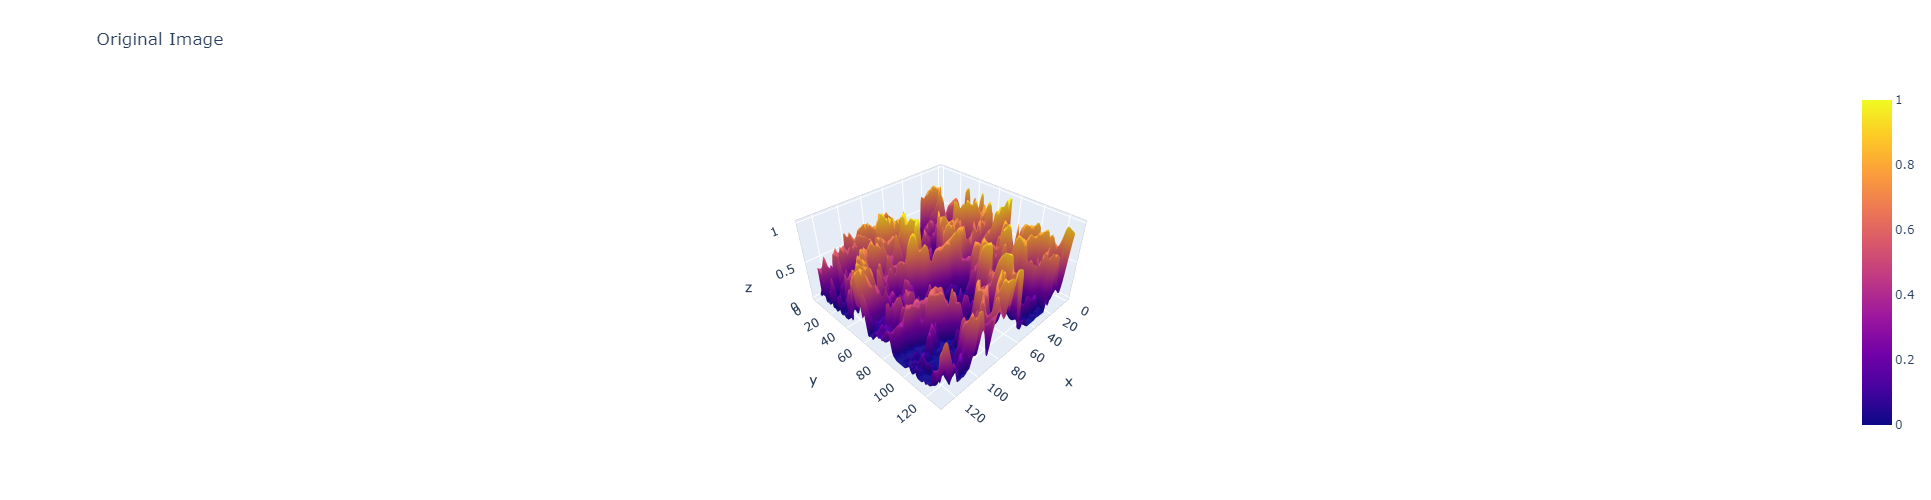

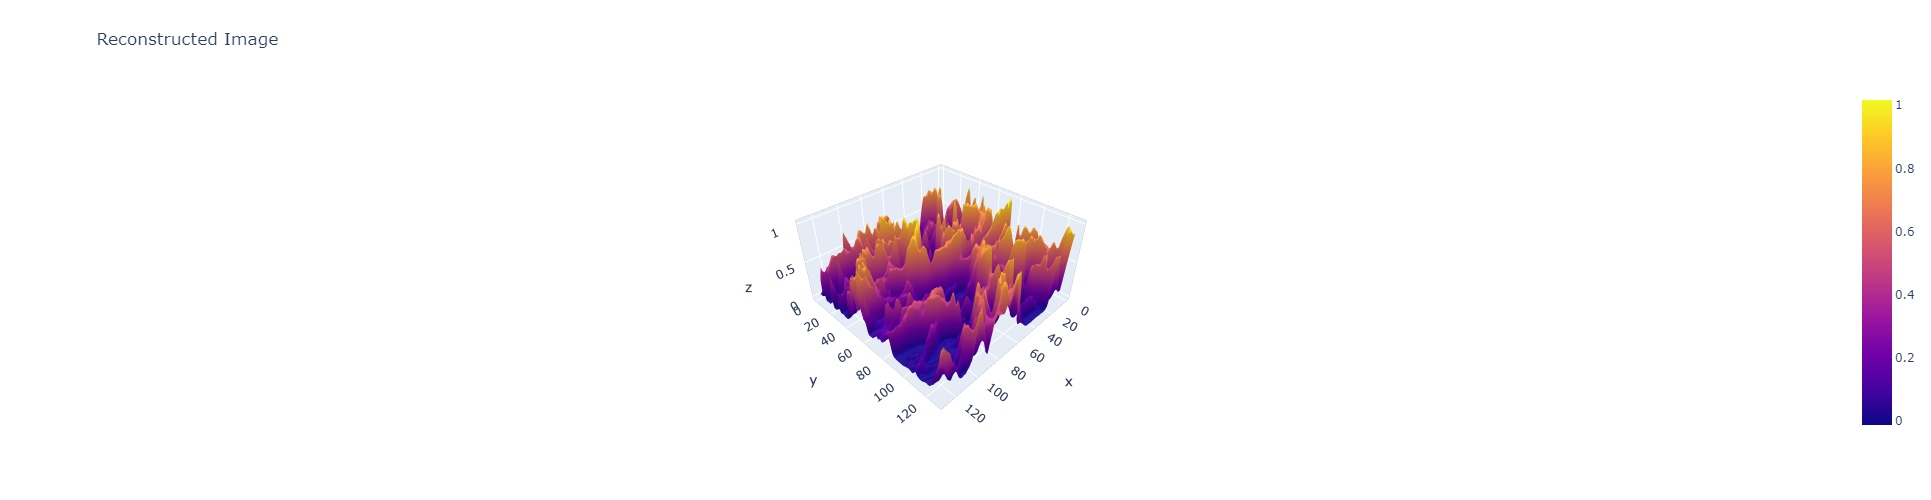

In [27]:
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print(filepath)
#filepath = 'testing/input/reslt_OR_7 (2)_index0_center_crop.tif'
img = np.array(imageio.imread(filepath))
orig_img = img[...,0]
down_img = img[...,1]
mask = img[...,2]
pred = saved_model.predict_generator(custom_generator_wrapper(testing_generator), steps=1)
image = pred[0,:,:,0]

figsize = (7,7)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')

ax.imshow(mask, cmap = 'gray')
print(mask.shape)
plt.show()
print('total elements in mask = '+ str(np.sum(mask>-1)))
print('total elements not downsampled = '+str(np.sum(mask)))
print('max value in mask = '+str(np.max(mask)))
print('min value in mask = '+str(np.min(mask)))
print('mean of mask = '+str(np.mean(mask)))

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(down_img, cmap = 'gray')
plt.title('Downsampled Image')
plt.show()

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image, cmap = 'gray')
plt.title('Reconstructed Image')
plt.show()

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(orig_img, cmap = 'gray')
plt.title('Original Image')
plt.show()

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.abs(orig_img - image), cmap = 'gray') #ax.imshow(skimage.util.invert(np.abs(image - img/np.max(img))), cmap = 'gray')
plt.title('Absolute Difference Image')
plt.show()
print('Mean Absolute Difference: ' + str(np.mean(np.abs(orig_img - image))))
print('Max Absolute Difference: ' + str(np.max(np.abs(orig_img - image))))

# xx, yy = np.mgrid[0:image.shape[0], 0:image.shape[1]]
# fig = plt.figure(figsize=figsize)
# ax = fig.gca(projection='3d')
# ax.plot_surface(xx, yy, image, rstride=1, cstride=1, cmap=plt.cm.gray,linewidth=2)
# ax.view_init(80, 30)
# plt.show()

# Interactive 3-D Plot
img = np.flip(orig_img, axis = 0)
sh_0, sh_1 = img.shape
x, y = np.linspace(1, sh_0, sh_0), np.linspace(1, sh_0, sh_1)
fig = go.Figure(data=[go.Surface(z=img, x=x, y=y)])
fig.update_layout(title='Original Image', autosize=False,
                  width=500, height=500,
                  scene = dict(aspectratio=dict(x=1, y=1, z=0.5)),
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

# Interactive 3-D Plot
image = np.flip(image, axis = 0)
sh_0, sh_1 = image.shape
x, y = np.linspace(1, sh_0, sh_0), np.linspace(1, sh_0, sh_1)
fig = go.Figure(data=[go.Surface(z=image, x=x, y=y)])
fig.update_layout(title='Reconstructed Image', autosize=False,
                  width=500, height=500,
                  scene = dict(aspectratio=dict(x=1, y=1, z=0.5)),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# Applying Model to Larger Images:

In [28]:
def expand_image(down_image, downsampling_ratio = [2, 5], downsampling_axis = 'x', output_shape = None):
    if downsampling_ratio[0]==0:
        downsampling_ratio[0]=1
    if downsampling_ratio[1]==0:
        downsampling_ratio[1]=1
    i_shape = down_image.shape[0]
    j_shape = down_image.shape[1]
    if output_shape == None:
        if downsampling_axis == 'x':
            i_shape_desired = i_shape
            j_shape_desired = int(j_shape * downsampling_ratio[1])
        elif downsampling_axis == 'y':
            i_shape_desired = int(i_shape * downsampling_ratio[0])
            j_shape_desired = j_shape
        elif downsampling_axis == 'both':
            i_shape_desired = int(i_shape * downsampling_ratio[0])
            j_shape_desired = int(j_shape * downsampling_ratio[1])
        else:
            print('ERROR: Please input x or y as downsampling axis')
    else:
        if output_shape[0] >= i_shape and output_shape[1] >= j_shape:
            i_shape_desired = output_shape[0]
            j_shape_desired = output_shape[1]
        else: 
            i_shape_desired = i_shape
            j_shape_desired = j_shape
    full_image = np.zeros((i_shape_desired, j_shape_desired), dtype = np.float32)
    #print(full_image.shape)
    decay_factor = 4
    if downsampling_axis == 'x':
        count = 0
        for j in range(j_shape_desired):
            if j%downsampling_ratio[1]==0 or j>=(j_shape_desired-downsampling_ratio[1]//2):
                if j%downsampling_ratio[1]==0:
                    full_image[:, j] = down_image[:, count]
                    count += 1
                else:
                    j_inter = j_shape_desired - j
                    full_image[:, j] = (j_inter/decay_factor)*down_image[:, count-1]    
    elif downsampling_axis == 'y':
        count = 0
        for i in range(i_shape_desired):
            if i%downsampling_ratio[0]==0 or i>=(i_shape_desired-downsampling_ratio[0]//2):
                if i%downsampling_ratio[0]==0:
                    full_image[i, :] = down_image[count, :]
                    count += 1
                else:
                    i_inter = i_shape_desired - i
                    full_image[i, :] = (i_inter/decay_factor)*down_image[count-1, :]                             
    elif downsampling_axis == 'both':
        i_count = 0
        for i in range(i_shape_desired):
            j_count = 0
            for j in range(j_shape_desired):
                if ((i%downsampling_ratio[0]==0 and j%downsampling_ratio[1]==0) or 
                    (i>=(i_shape_desired-downsampling_ratio[0]//2) or j>=(j_shape_desired-downsampling_ratio[1]//2))):
                    #print('index = '+str(i) + ', ' + str(j))
                    if (i%downsampling_ratio[0]==0 and j%downsampling_ratio[1]==0):
                        full_image[i, j] = down_image[i_count, j_count]
                    elif i>=(i_shape_desired-downsampling_ratio[0]//2) and j%downsampling_ratio[1]==0:
                        i_inter = i_shape_desired - i
                        full_image[i, j] = (i_inter/decay_factor)*down_image[i_count-1, j_count]
                    elif  j>=(j_shape_desired-downsampling_ratio[1]//2) and i%downsampling_ratio[0]==0:
                        j_inter = j_shape_desired - j
                        full_image[i, j] = (j_inter/decay_factor)*down_image[i_count, j_count-1]
                    elif i>=(i_shape_desired-downsampling_ratio[0]//2) and j>=(j_shape_desired-downsampling_ratio[1]//2):
                        i_inter = i_shape_desired - i
                        j_inter = j_shape_desired - j
                        rest_vec = np.sqrt(i_inter**2 + j_inter**2)
                        full_image[i, j] = (rest_vec/decay_factor)*down_image[i_count-1, j_count-1]
                    #print('count = '+str(i_count) + ', ' + str(j_count))
                if j%downsampling_ratio[1]==0:
                    j_count += 1
            if i%downsampling_ratio[0]==0:
                i_count += 1
    else:
        print('ERROR: Please input x or y as downsampling axis')
    full_image = exposure.rescale_intensity(full_image, in_range='image', out_range=(0.0,1.0))
    return full_image

In [29]:
def fix_boundaries(orig_img, patch_img, model, i_count, j_count, pad_image_shape, model_input_shape = (128,128), bound_buff = 4):
    img = patch_img
    if i_count == 1:
        if j_count > 1:
            for j in range(model_input_shape[1]//2,pad_image_shape[1]-model_input_shape[1]//2,model_input_shape[1]):
                patch = orig_img[:,j:j+model_input_shape[1]]
                #print(patch.shape)
                patch = patch[..., None]
                pred = model.predict(patch[None], batch_size = 1)
                pred = pred[0,:,:,0]

                #plt.imshow(pred, cmap='gray')
                #plt.show()
                mid_patch = j+model_input_shape[1]//2
                img[:,mid_patch-bound_buff:mid_patch+bound_buff] = pred[:, pred.shape[1]//2-bound_buff:pred.shape[1]//2+bound_buff]
    else:
        for i in range(0,pad_image_shape[0],model_input_shape[0]):
            for j in range(model_input_shape[1]//2,pad_image_shape[1]-model_input_shape[1]//2,model_input_shape[1]):
                patch = orig_img[i:i+model_input_shape[0],j:j+model_input_shape[1]]
                patch = patch[..., None]
                pred = model.predict(patch[None], batch_size = 1)
                pred = pred[0,:,:,0]

                #plt.imshow(pred, cmap='gray')
                #plt.show()
                mid_patch = j+model_input_shape[1]//2
                #plt.imshow(img[i:i+model_input_shape[1],mid_patch-bound_buff:mid_patch+bound_buff], cmap='gray')
                #plt.show()
                #'''
                # TO NOT SHOW PATCH PATTERN
                img[i:i+model_input_shape[0],
                    mid_patch-bound_buff:mid_patch+bound_buff] = pred[:, pred.shape[1]//2-bound_buff:pred.shape[1]//2+bound_buff]
                #'''
                '''
                # TO SHOW PATCH PATTERN
                img[i:i+model_input_shape[0],
                    mid_patch-bound_buff:mid_patch+bound_buff] = np.ones(pred[:, pred.shape[1]//2-bound_buff:
                                                                              pred.shape[1]//2+bound_buff].shape)
                '''
                #plt.imshow(img[i:i+model_input_shape[0],mid_patch-bound_buff:mid_patch+bound_buff], cmap='gray')
                #plt.show()
        for j in range(0,pad_image_shape[1],model_input_shape[1]):
            for i in range(model_input_shape[0]//2,pad_image_shape[0]-model_input_shape[0]//2,model_input_shape[0]):
                patch = orig_img[i:i+model_input_shape[0],j:j+model_input_shape[1]]
                patch = patch[..., None]
                pred = model.predict(patch[None], batch_size = 1)
                pred = pred[0,:,:,0]

                #plt.imshow(pred, cmap='gray')
                #plt.show()
                mid_patch = i+model_input_shape[0]//2
                #'''
                # TO NOT SHOW PATCH PATTERN
                img[mid_patch-bound_buff:mid_patch+bound_buff, 
                    j:j+model_input_shape[1]] = pred[pred.shape[0]//2-bound_buff:pred.shape[0]//2+bound_buff,:]
                #'''
                '''
                # TO SHOW PATCH PATTERN
                img[mid_patch-bound_buff:mid_patch+bound_buff, 
                    j:j+model_input_shape[1]] = np.zeros(pred[pred.shape[0]//2-bound_buff:
                                                              pred.shape[0]//2+bound_buff,:].shape)
                '''
        # Cover Overlap
        pad = bound_buff//4+1
        bound_buff += pad
        for i in range(model_input_shape[0]//2,pad_image_shape[0]-model_input_shape[0]//2,model_input_shape[0]):
            for j in range(model_input_shape[1]//2,pad_image_shape[1]-model_input_shape[1]//2,model_input_shape[1]):
                patch = orig_img[i:i+model_input_shape[0],j:j+model_input_shape[1]]
                patch = patch[..., None]
                pred = model.predict(patch[None], batch_size = 1)
                pred = pred[0,:,:,0]
                
                #plt.imshow(pred, cmap='gray')
                #plt.show()
                mid_patch_i = i+model_input_shape[0]//2
                mid_patch_j = j+model_input_shape[1]//2
                #plt.imshow(img[i:i+model_input_shape[1],mid_patch-bound_buff:mid_patch+bound_buff], cmap='gray')
                #plt.show()
                #'''
                # TO NOT SHOW PATCH PATTERN
                img[mid_patch_i-bound_buff:mid_patch_i+bound_buff,
                    mid_patch_j-bound_buff:mid_patch_j+bound_buff] = pred[pred.shape[0]//2-bound_buff:pred.shape[0]//2+bound_buff, 
                                                                          pred.shape[1]//2-bound_buff:pred.shape[1]//2+bound_buff]
                #'''
                '''
                # TO SHOW PATCH PATTERN
                img[mid_patch_i-bound_buff:mid_patch_i+bound_buff,
                    mid_patch_j-bound_buff:mid_patch_j+bound_buff] = 0.5*np.ones(pred[pred.shape[0]//2-bound_buff:pred.shape[0]//2+bound_buff, 
                                                                                      pred.shape[1]//2-bound_buff:pred.shape[1]//2+bound_buff].shape)
                '''
                #plt.imshow(img[i:i+model_input_shape[0],mid_patch-bound_buff:mid_patch+bound_buff], cmap='gray')
                #plt.show()
        
    return img

In [30]:
def apply_model_patchwork(model, down_image, downsampling_ratio = 2, downsampling_axis = 'x', 
                          shape_for_model = (128,128), buffer = 10, output_shape = None):
    
    # This Function Expands the Image and Then Performs Model Patchwork Algorithm
    STARTING_POINT = (0,0)
    i_shape = down_image.shape[0]
    j_shape = down_image.shape[1]
    full_image = expand_image(down_image, downsampling_ratio = downsampling_ratio, 
                              downsampling_axis = downsampling_axis, output_shape = output_shape)
    full_i_shape = full_image.shape[0]
    full_j_shape = full_image.shape[1]
    default_pad = np.max(shape_for_model)//2
    #default_pad = 0
    if full_i_shape%shape_for_model[0] != 0:
        i_left = full_i_shape%shape_for_model[0]
        i_pad = (shape_for_model[0] - i_left)//2
        rest_i = (shape_for_model[0] - i_left)%2
    else:
        i_left = 0
        i_pad = default_pad
        rest_i = 0
    if full_j_shape%shape_for_model[1] != 0:
        j_left = full_j_shape%shape_for_model[1]
        j_pad = (shape_for_model[1] - j_left)//2
        rest_j = (shape_for_model[1] - j_left)%2
    else:
        j_left = 0
        j_pad = default_pad
        rest_j = 0
    
    #print('i_left = '+str(i_left))
    #print('j_left = '+str(j_left))
    #print('i_pad = '+str(i_pad))
    #print('j_pad = '+str(j_pad))
    #print('rest_i = '+str(rest_i))
    #print('rest_j = '+str(rest_j))
    pad_image = np.pad(full_image, [(i_pad, ), (j_pad, )], mode='constant')
    full_pad_image = np.pad(pad_image, [(0, rest_i), (0, rest_j)], mode='constant')
    
    '''
    figsize = (15,15)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(full_pad_image, cmap = 'gray')
    plt.show()
    '''
    
    orig_image_j_start = j_pad #+ rest_j
    orig_image_i_start = i_pad #+ rest_i
    orig_image_j_end = orig_image_j_start + full_j_shape
    orig_image_i_end = orig_image_i_start + full_i_shape
    #print(orig_image_i_start)
    #print(orig_image_i_end)
    #print(orig_image_j_start)
    #print(orig_image_j_end)
    full_patch_image = np.ones(full_pad_image.shape)
    i_count = 0
    for i in range(0,full_pad_image.shape[0],shape_for_model[0]):
        j_count = 0
        batch = np.zeros((full_pad_image.shape[1]//shape_for_model[1], 
                          shape_for_model[0], shape_for_model[1]))
        #print(batch.shape)
        for j in range(0,full_pad_image.shape[1],shape_for_model[1]):
            patch = full_pad_image[i:i+shape_for_model[0], j:j+shape_for_model[1]]
            start_i_temp =i_count*shape_for_model[0]
            end_i_temp = (i_count+1)*shape_for_model[0]
            start_j_temp = j_count*shape_for_model[1]
            end_j_temp = (j_count+1)*shape_for_model[1]
            #full_patch_image[start_i_temp:end_i_temp, start_j_temp:end_j_temp] = patch
            #plt.imshow(patch, cmap='gray')
            #plt.show()
            patch = patch[..., None]
            pred = model.predict(patch[None], batch_size = 1)
            #plt.imshow(pred[0,:,:,0], cmap='gray')
            #plt.show()
            full_patch_image[start_i_temp:end_i_temp, start_j_temp:end_j_temp] = pred[0,:,:,0]
            j_count +=1
        i_count +=1
    #'''
    if i_count > 1 or j_count > 1:
        full_patch_image = fix_boundaries(full_pad_image, full_patch_image, model, i_count, j_count, pad_image_shape = full_pad_image.shape,
                                          model_input_shape = shape_for_model, bound_buff = buffer)
    #'''
    #start_i_temp = orig_image_i_start + i_count*shape_for_model[0]
    #end_i_temp = orig_image_i_start + (i_count+1)*shape_for_model[0]
    #start_j_temp = orig_image_j_start + j_count*shape_for_model[1]
    #end_j_temp = orig_image_j_start + (j_count+1)*shape_for_model[1]
    #print('start_i_temp = '+str(start_i_temp))
    #print('end_i_temp = '+str(end_i_temp))
    #print('start_j_temp = '+str(start_j_temp))
    #print('end_j_temp = '+str(end_j_temp))
    full_recon_image = full_patch_image[orig_image_i_start:orig_image_i_end,orig_image_j_start:orig_image_j_end]
    full_recon_image = exposure.rescale_intensity(full_recon_image, in_range='image', out_range=(0.0,1.0))
    #'''
    # Post Processing to Remove Salt-Pepper Throwing Off Contrast
    full_recon_image = scipy.ndimage.median_filter(full_recon_image, footprint=((1,0,0),(0,1,0),(0,0,1)))
    full_recon_image = scipy.ndimage.median_filter(full_recon_image, footprint=((0,1,0),(0,1,0),(0,1,0)))
    full_recon_image = scipy.ndimage.median_filter(full_recon_image, footprint=((0,0,1),(0,1,0),(1,0,0)))
    full_recon_image = scipy.ndimage.median_filter(full_recon_image, footprint=((0,0,0),(1,1,1),(0,0,0)))
    #'''
    #full_recon_image = exposure.equalize_hist(full_recon_image, nbins=2**(13))
    full_recon_image = exposure.rescale_intensity(full_recon_image, in_range='image', out_range=(0.0,1.0))
    return full_recon_image

Directory:testing/input\brain_image_crop_1_128by128_pad.tif


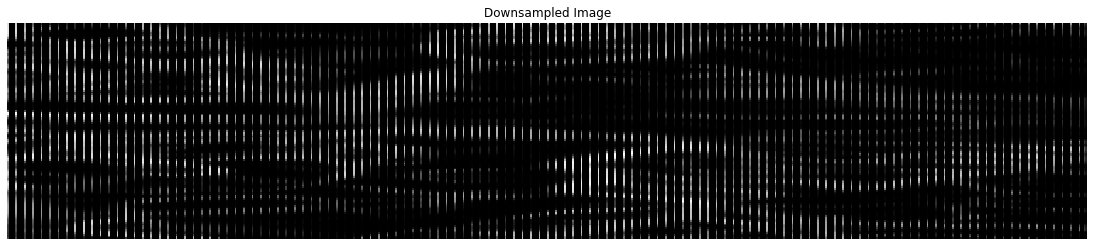

Augmented Shape: (128, 640)
20.2880859375 %


In [273]:
dir_name = 'testing/input'
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print('Directory:' + filepath)
#filepath = 'testing/input/reslt_OR_7 (2)_index0_center_crop.tif'
img = np.array(imageio.imread(filepath))
img = img[...,0]
full = expand_image(down_image = img, downsampling_ratio = [0,5], downsampling_axis = 'both')
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full, cmap = 'gray')
plt.title('Downsampled Image')
plt.show()
print('Augmented Shape: ' + str(full.shape))
print(str((np.sum(full>0)/(full.shape[0]*full.shape[1]))*100) + ' %')

In [37]:
dir_name = 'testing/input'
saved_model = best_unet_model

Directory: testing/input\brain_image_crop_1_128by128_pad.tif


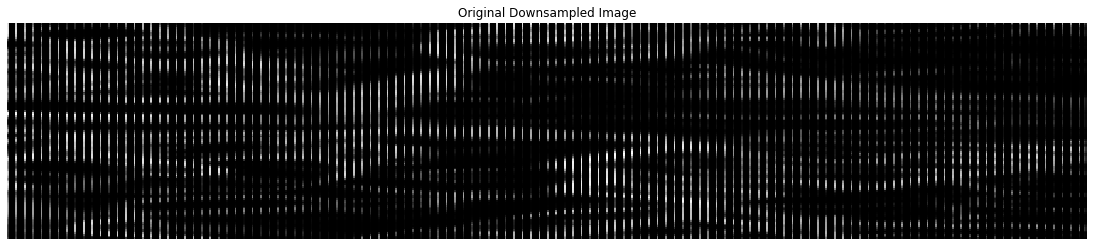

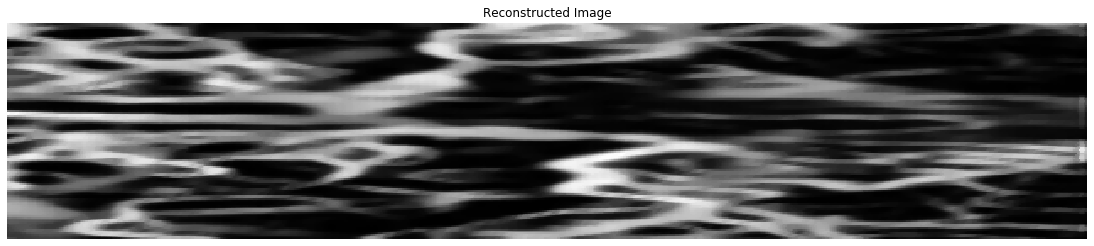

Augmented Shape: (128, 640)
20.2880859375 %


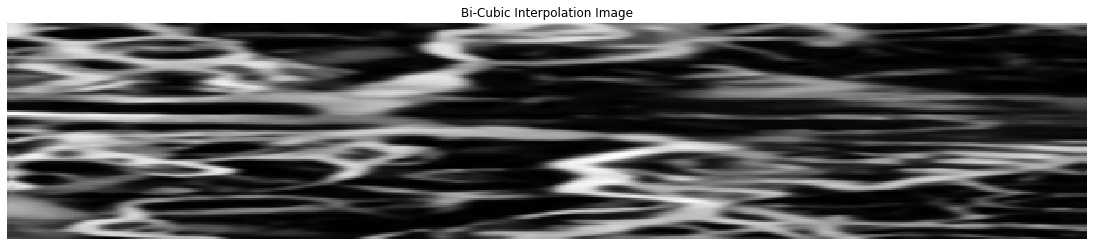

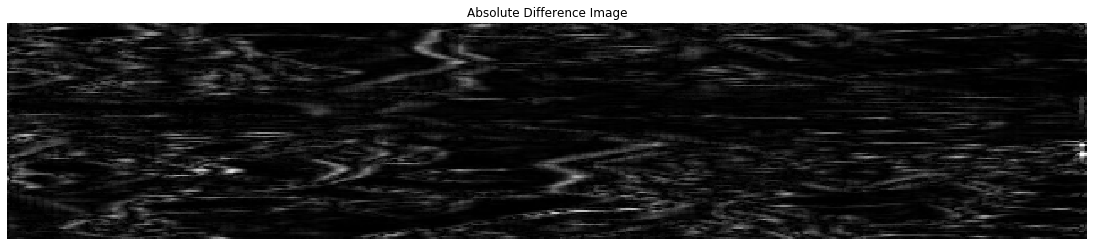

Mean Absolute Difference: 0.026820765609469877
Max Absolute Difference: 0.3905751764701339


In [31]:
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print('Directory: ' + filepath)
#filepath = 'testing/input/reslt_OR_7 (2)_index0_center_crop.tif'
orig_img = np.array(imageio.imread(filepath))
'''
# If using color images
if len(img.shape)>2:
    img = np.mean(img, axis = 2)
'''
img = orig_img[...,0]
img = exposure.rescale_intensity(img, in_range='image', out_range=(0.0,1.0))
img = np.pad(img, [(0, 0), (0, 0)], mode='constant')
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
full = expand_image(down_image = img, downsampling_ratio = [1,5], downsampling_axis = 'both')
ax.imshow(full, cmap = 'gray')
plt.title('Original Downsampled Image')
plt.show()
full_image = apply_model_patchwork(saved_model, down_image = img, downsampling_ratio = [1,5], 
                                   downsampling_axis = 'both', shape_for_model = (128,128), buffer = 20)
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_image, cmap = 'gray')
plt.title('Reconstructed Image')
plt.show()
print('Augmented Shape: ' + str(full.shape))
print(str((np.sum(full>0)/(full.shape[0]*full.shape[1]))*100) + ' %')

# COMPARISON TO INTERPOLATION:
# From https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp
# and https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
i_expansion_ratio = 1
j_expansion_ratio = 5
interp_img = skimage.transform.resize(img, output_shape = (img.shape[0]*i_expansion_ratio,img.shape[1]*j_expansion_ratio), 
                                      order=3, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=True, 
                                      anti_aliasing_sigma=None)
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image')
plt.show()

# DIFFERENCE IMAGE:
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.abs(interp_img - full_image), cmap = 'gray')
plt.title('Absolute Difference Image')
plt.show()
print('Mean Absolute Difference: ' + str(np.mean(np.abs(interp_img - full_image))))
print('Max Absolute Difference: ' + str(np.max(np.abs(interp_img - full_image))))

Directory: testing/input\brain_image_crop_1_128by128_pad.tif


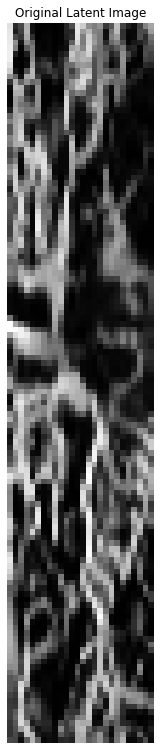

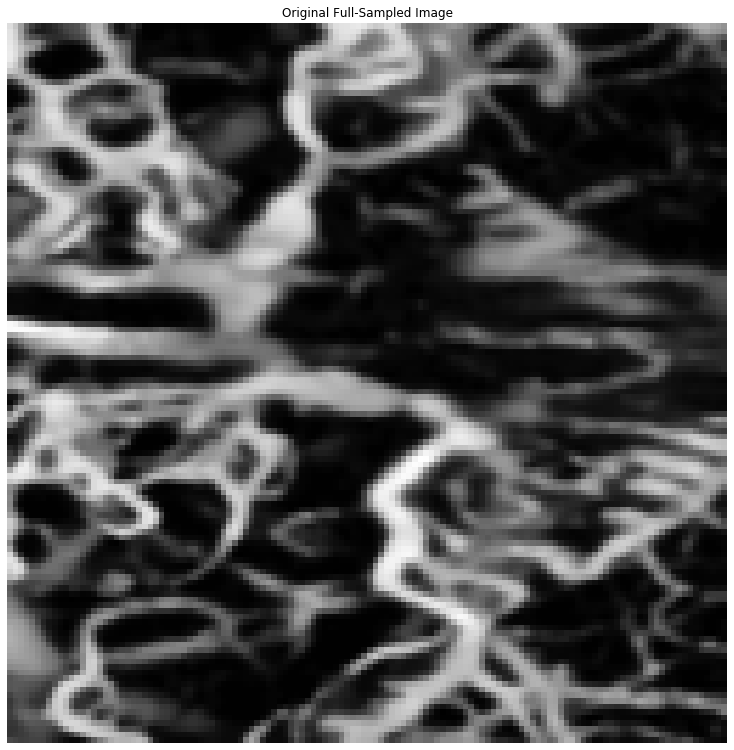

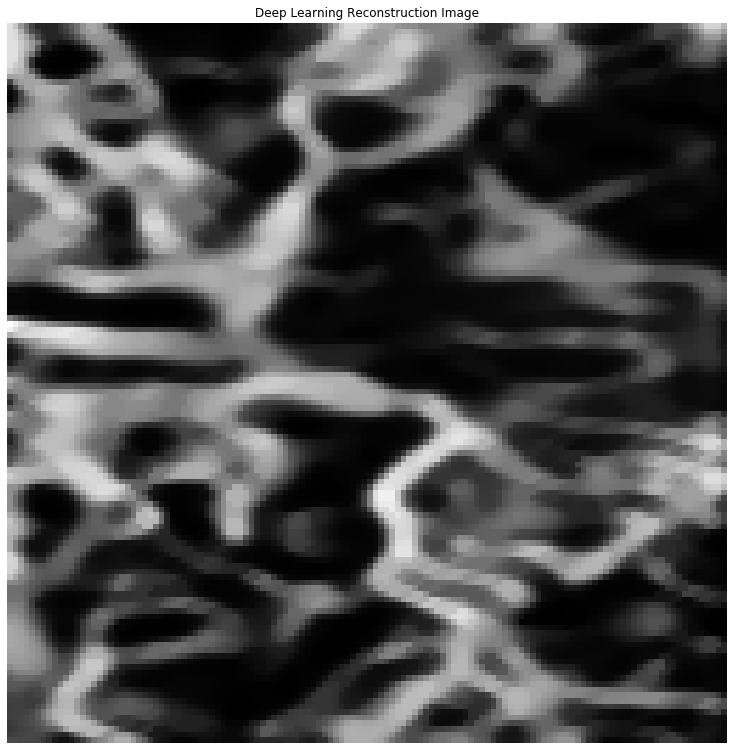

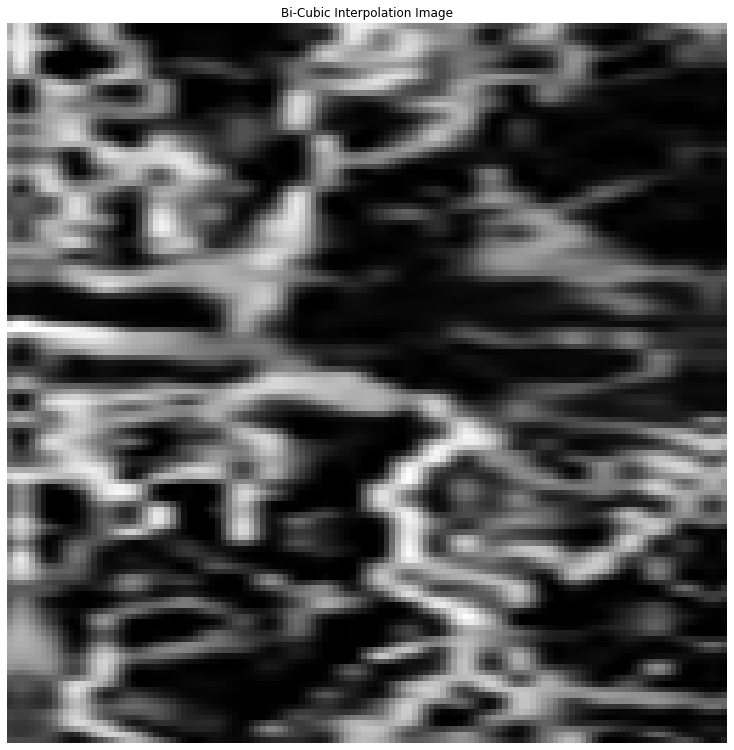

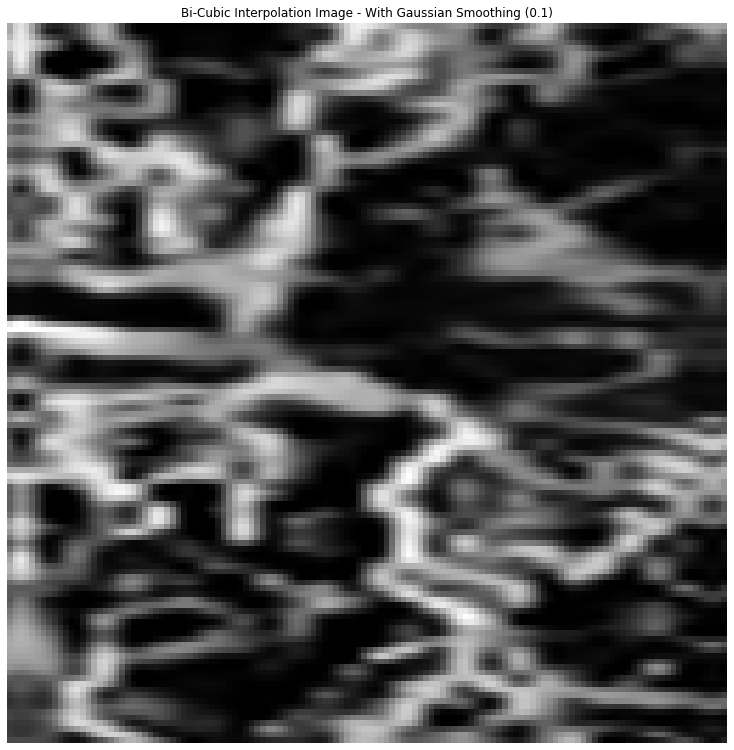

---------------------------------------
##########LIST OF STATISTICS:##########
---------------------------------------
COMPARISON OF PSNR:
Deep Learning: 21.69109
Bicubic Interp: 19.27721
COMPARISON OF SSIM:
Deep Learning: 0.8177524
Bicubic Interp: 0.78868335
COMPARISON OF MEAN ABSOLUTE ERROR:
Deep Learning: 0.051837675
Bicubic Interp: 0.066905364
COMPARISON OF MEAN SQUARED ERROR:
Deep Learning: 0.006774714
Bicubic Interp: 0.01181079
COMPARISON OF KL DIVERGENCE:
Deep Learning: 0.01609281
Bicubic Interp: 0.019096494
COMPARISON OF MEAN SQUARED LOGARITHMIC ERROR:
Deep Learning: 0.0036217065
Bicubic Interp: 0.0063040997
COMPARISON OF LOG COSH ERROR:
Deep Learning: 0.0033615401
Bicubic Interp: 0.0058149975
COMPARISON OF POISSON LOSS:
Deep Learning: 0.52688384
Bicubic Interp: 0.540255


In [32]:
dir_name = 'testing/input'
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print('Directory: ' + filepath)
#filepath = 'testing/input/reslt_OR_7 (2)_index0_center_crop.tif'
orig_img = np.array(imageio.imread(filepath))
full_samp_img = exposure.rescale_intensity(orig_img[...,0], in_range='image', out_range=(0.0,1.0))
down_samp_img = exposure.rescale_intensity(orig_img[...,1], in_range='image', out_range=(0.0,1.0))
'''
# If using color images
if len(img.shape)>2:
    img = np.mean(img, axis = 2)
'''
# Recover Latent Image:
downsampling_ratio = [1,5]
latent_image = np.zeros((int(np.ceil(down_samp_img.shape[0]/downsampling_ratio[0])), 
                         int(np.ceil(down_samp_img.shape[1]/downsampling_ratio[1]))))
i_count = 0
for i in range(0, down_samp_img.shape[0], downsampling_ratio[0]):
    j_count = 0
    for j in range(0, down_samp_img.shape[1], downsampling_ratio[1]):
        latent_image[i_count, j_count] = down_samp_img[i, j]
        if j%downsampling_ratio[1]==0:
            j_count += 1
    if i%downsampling_ratio[0]==0:
        i_count += 1
figsize = (10,10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(latent_image, cmap = 'gray')
plt.title('Original Latent Image')
plt.show()

figsize = (10,10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_samp_img, cmap = 'gray')
plt.title('Original Full-Sampled Image')
plt.show()
#saved_model = best_unet_model
deep_image = apply_model_patchwork(saved_model, down_image = latent_image, downsampling_ratio = [1,5], 
                                   downsampling_axis = 'both', shape_for_model = (128,128), 
                                   buffer = 20, output_shape = (128,128))
figsize = (10,10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(deep_image, cmap = 'gray')
plt.title('Deep Learning Reconstruction Image')
plt.show()

# COMPARISON TO INTERPOLATION:
# From https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp
# and https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
downsampling_ratio = [1,5]
interp_img = skimage.transform.resize(latent_image, output_shape=(128,128), 
                                      order=3, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=True, 
                                      anti_aliasing_sigma=None)
figsize = (10,10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image')
plt.show()

gauss_interp_img = scipy.ndimage.gaussian_filter(interp_img, sigma=0.1, order=0, output=None, mode='reflect', cval=0.0, truncate=3.0)
interp_img = gauss_interp_img
figsize = (10,10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(gauss_interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image - With Gaussian Smoothing (0.1)')
plt.show()

# Quantitative Measurements
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
#from model_utils import TV
deep_image = deep_image[..., None]
deep_image = tf.image.convert_image_dtype(deep_image[None, ...], tf.float32)
interp_img = interp_img[..., None]
interp_img = tf.image.convert_image_dtype(interp_img[None, ...], tf.float32)
full_samp_img = full_samp_img[..., None]
full_samp_img = tf.image.convert_image_dtype(full_samp_img[None, ...], tf.float32)
print('---------------------------------------')
print('##########LIST OF STATISTICS:##########')
print('---------------------------------------')
print('COMPARISON OF PSNR:')
print('Deep Learning: ' + str(PSNR(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(PSNR(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF SSIM:')
print('Deep Learning: ' + str(SSIM(full_samp_img, deep_image).numpy()[0]))
print('Bicubic Interp: ' + str(SSIM(full_samp_img, interp_img).numpy()[0]))
print('COMPARISON OF MEAN ABSOLUTE ERROR:')
MAE = tf.keras.losses.MeanAbsoluteError()
print('Deep Learning: ' + str(MAE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MAE(full_samp_img, interp_img).numpy()))
print('COMPARISON OF MEAN SQUARED ERROR:')
MSE = tf.keras.losses.MeanSquaredError()
print('Deep Learning: ' + str(MSE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MSE(full_samp_img, interp_img).numpy()))
#print('COMPARISON OF TOTAL VARIATION:')
#print('Deep Learning: ' + str(TV(full_samp_img, deep_image).numpy()))
#print('Bicubic Interp: ' + str(TV(full_samp_img, interp_img).numpy()))
print('COMPARISON OF KL DIVERGENCE:')
print('Deep Learning: ' + str(KLDivergence(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(KLDivergence(full_samp_img, interp_img).numpy()))
print('COMPARISON OF MEAN SQUARED LOGARITHMIC ERROR:')
MSLE = tf.keras.losses.MeanSquaredLogarithmicError()
print('Deep Learning: ' + str(MSLE(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(MSLE(full_samp_img, interp_img).numpy()))
print('COMPARISON OF LOG COSH ERROR:')
LCOSH = tf.keras.losses.LogCosh()
print('Deep Learning: ' + str(LCOSH(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(LCOSH(full_samp_img, interp_img).numpy()))
print('COMPARISON OF POISSON LOSS:')
PL = tf.keras.losses.Poisson()
print('Deep Learning: ' + str(PL(full_samp_img, deep_image).numpy()))
print('Bicubic Interp: ' + str(PL(full_samp_img, interp_img).numpy()))

# Scratchpad

In [ ]:
data = np.empty(1)
print(data.shape)
dir = 'converted_data'
iter = 0
for file in os.listdir(dir):
        filename = os.fsdecode(file)
        temp = np.load(dir+'/'+filename)
        temp = temp[..., None]
        print(temp.shape)
        data[iter, :, :, :] = temp
        iter += 1 

In [ ]:
im = Image.open('./data/train/190304_brain 1_Image0.tif')

In [ ]:
im.show()

In [ ]:
imarray = np.array(im)*255

In [ ]:
np.max(imarray)

In [ ]:
im = Image.fromarray(imarray)

In [ ]:
im.show()

In [ ]:
d = next(train_generator)
print(d[0][0][0][0])

In [ ]:
print(train_dir)

In [ ]:
W = np.ones((5,5))*2
inp = np.ones((5, 5))*3
inp = inp[None, ...]
out = np.multiply(W, inp)
print(out.shape)
print(inp.shape)

In [ ]:
print(out[2:])

In [ ]:
A = np.ones((800,1800, 5))
A_avg = np.sum(A, axis = 2)
print(np.min(A_avg))

In [ ]:
array_dict = {'key1': np.zeros((10,10,10,10)), 'key2': 20, 'map_530': 25, 'map_all': 30}
search_keys = ['map_530', 'key1']
#filtered_dict = dict(filter(lambda item: search_key[0] search_key[1] in item[0], array_dict.items()))
filtered_dict = {}
for i in range(len(search_keys)):
    search_key = search_keys[i]
    if search_key in array_dict:
        filtered_dict[search_key] = array_dict[search_key]

In [ ]:
print(filtered_dict)

In [ ]:
print(len(filtered_dict))

In [37]:
A = np.random.randn(1000,2000)
B = exposure.rescale_intensity(A, in_range='image', out_range=(0,1))
print(np.max(A))
print(np.mean(B))

5.037808862416426
0.47774941874803667


In [150]:
A = np.zeros((10,10))
B = np.ones((10,10))
C = np.array([A, B])
print(C.shape)
D = np.hstack(C)
print(D)
E = np.concatenate(D, axis = 0)
print(E.shape)
print(E)

(2, 10, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(200,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 

In [67]:
print(int(tf.random.uniform(shape=[1], minval = 0, maxval = 5, dtype=tf.float32).numpy()[0]))

0


In [187]:
A = [1,2,3,4,5]
B = [1,2,3,4,5]
random.seed(a=1)
random.shuffle(A)
random.shuffle(B)
print(A)
print(B)

[3, 4, 5, 1, 2]
[1, 3, 2, 5, 4]


In [178]:
a = range(6)
for i in a:
    print(i)

0
1
2
3
4
5


In [317]:
print(1%10)

1


In [11]:
np.nan*0

nan